In [1]:
# This code shows how to get median uncertainties for samples using bootstrap resampling with and without errorbars on the individual measurements

In [2]:
### read in the necessary packages

from astropy.io import fits
from astropy.table import Table
from astropy.stats import bootstrap

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [3]:
### read in the data

# SDSS emission-line catalog
emline_dat = Table.read('/home/jordan/Documents/MOSDEF_research/data/sdss_dr7_linemeas_latest.fits', format='fits')
emline_df = emline_dat.to_pandas()
print(emline_df)

        PLATEID  FIBERID  H_ALPHA_FLUX  H_ALPHA_FLUX_ERR  H_BETA_FLUX  \
0           266        1    462.117584         10.688581    98.786781   
1           266        2     15.469431          6.547065     8.996722   
2           266        4     18.467436          7.449744     6.541351   
3           266        5      0.000000         -0.811374   -11.287027   
4           266        6    181.526215          3.646693    47.366501   
...         ...      ...           ...               ...          ...   
927547     2974      633     12.875943          2.346492     1.761674   
927548     2974      635     62.370274          5.478751    17.035000   
927549     2974      636     13.253593          3.914706     2.430622   
927550     2974      637     14.686159          2.942574     5.930055   
927551     2974      638      0.217731          2.558428     5.126189   

        H_BETA_FLUX_ERR  OII_3726_FLUX  OII_3726_FLUX_ERR  OII_3729_FLUX  \
0              6.727546     307.001404        2

In [4]:
### Here I remove all galaxies with negative flux values to remove absorption lines and/or poor measurements just to ensure a quality dataset of emission-lines

emline_df.drop(emline_df[emline_df['H_ALPHA_FLUX'] <= 0].index, inplace = True)
print(len(emline_df))

### note that doing this would also work
#emline_df_filtered = emline_df[emline_df['H_ALPHA_FLUX'] > 0]
#print(len(emline_df_filtered))

838314


In [5]:
### Here I remove all galaxies with negative flux uncertainty values to remove any potential bad measurements

emline_df.drop(emline_df[emline_df['H_ALPHA_FLUX_ERR'] <= 0].index, inplace = True)
print(len(emline_df))
# note that none were actually removed

838314


In [6]:
# the full SDSS sample is massive with over 800,000 objects
# to speed up this example, I'm going to only use the first 200 rows that fit this above Ha flux criteria 
emline_df = emline_df.head(200)
print(emline_df)

     PLATEID  FIBERID  H_ALPHA_FLUX  H_ALPHA_FLUX_ERR  H_BETA_FLUX  \
0        266        1    462.117584         10.688581    98.786781   
1        266        2     15.469431          6.547065     8.996722   
2        266        4     18.467436          7.449744     6.541351   
4        266        6    181.526215          3.646693    47.366501   
5        266        8     13.805779          2.949589    -1.125585   
..       ...      ...           ...               ...          ...   
218      266      280    190.142883          2.955572    46.887146   
220      266      283    168.464188          3.071349    41.293507   
221      266      284     15.244759          6.840655    11.772693   
222      266      285     72.670258          2.114458    18.126863   
223      266      286    112.945450          3.182256    32.081799   

     H_BETA_FLUX_ERR  OII_3726_FLUX  OII_3726_FLUX_ERR  OII_3729_FLUX  \
0           6.727546     307.001404        2327.570801      34.059772   
1           3

In [7]:
### function to estimate median uncertainty for a quantity NOT including uncertainties

def median_w_bootstrap_uncertainty(data, data_name):
    bootstrap_function = bootstrap(data, 10000) # the 10000 is the number of times the data is resampled
    median_array = []
    for i in range(0, len(bootstrap_function), 1):
        median_array.append(np.median(bootstrap_function[i]))
    print("Median ", data_name, " = ", np.median(data), "+/-", np.std(median_array)) # this prints "median +/- uncertainty"
    median_uncertainty = np.std(median_array)
    return median_uncertainty # this returns the median uncertainty for later use

In [8]:
### estimate median Ha flux (without flux uncertainties)

med_ha_err = median_w_bootstrap_uncertainty(emline_df["H_ALPHA_FLUX"].values, "Ha flux")

Median  Ha flux  =  45.06769561767578 +/- 8.845510813600852


In [9]:
print(med_ha_err)

8.845510813600852


In [10]:
### estimate median Ha flux (with flux uncertainties)
# note that this step takes a bit of time because the SDSS sample is so large (~800,000 galaxies)

med_ha_arr = []
for i in range(10000):
    randind = np.random.randint(len(emline_df["H_ALPHA_FLUX"].values), size=len(emline_df["H_ALPHA_FLUX"].values))   # this line selects N random integers ranging from 0 to N, where N is the size of the dataset, i.e., it gives the indices for resampling w/ replacement
    ha_flux_new = np.random.normal(emline_df["H_ALPHA_FLUX"].values[randind], emline_df["H_ALPHA_FLUX_ERR"].values[randind])  # this line resamples before perturbing according to the normal measurment errors
    ha_flux_m = np.median(ha_flux_new)
    med_ha_arr.append(ha_flux_m)

med_ha_err_v2 = np.std(med_ha_arr)


In [11]:
print(med_ha_err_v2)
print(np.max(emline_df["H_ALPHA_FLUX"].values))

8.384068017559999
21890.451171875


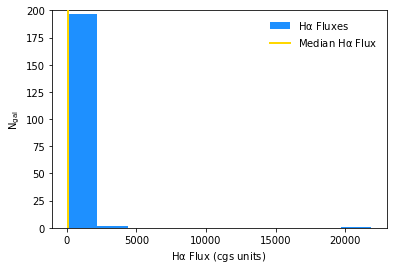

In [12]:
### plot the distribution with the medians 

# full distribution
plt.hist(emline_df["H_ALPHA_FLUX"].values, color="dodgerblue", label=r'$\rm H\alpha \ Fluxes$')
plt.errorbar(np.median(emline_df["H_ALPHA_FLUX"].values), [0,1000], color='gold', linewidth=2, zorder=1000, label=r'$\rm Median \ H\alpha \ Flux$')
plt.axvspan(np.median(emline_df["H_ALPHA_FLUX"].values)-med_ha_err_v2, np.median(emline_df["H_ALPHA_FLUX"].values)+med_ha_err_v2, alpha=0.6, color='gold', zorder=1000)
plt.ylim([0,200])
plt.xlabel(r'$\rm H\alpha \ Flux \ (cgs \ units)$')#, fontsize=40)
plt.ylabel(r'$\rm N_{gal}$')#, fontsize=40)
plt.legend(loc="upper right", frameon=False)
plt.show()

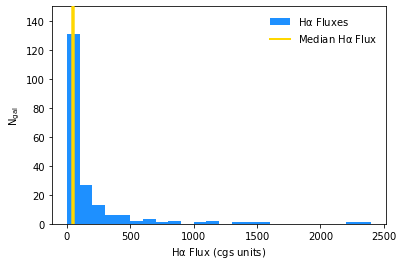

In [13]:
### the one outlier with very high Ha flux makes the plot difficult to read, so let's not show it on the plot

plt.hist(emline_df["H_ALPHA_FLUX"].values, bins=np.arange(0, 2500, 100), color="dodgerblue", label=r'$\rm H\alpha \ Fluxes$')
plt.errorbar(np.median(emline_df["H_ALPHA_FLUX"].values), [0,1000], color='gold', linewidth=2, zorder=1000, label=r'$\rm Median \ H\alpha \ Flux$')
plt.axvspan(np.median(emline_df["H_ALPHA_FLUX"].values)-med_ha_err_v2, np.median(emline_df["H_ALPHA_FLUX"].values)+med_ha_err_v2, alpha=0.6, color='gold', zorder=1000)
plt.ylim([0,150])
plt.xlabel(r'$\rm H\alpha \ Flux \ (cgs \ units)$')
plt.ylabel(r'$\rm N_{gal}$')
plt.legend(loc="upper right", frameon=False)
plt.show()

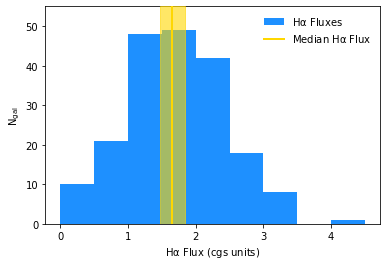

In [14]:
### the graph is still a little hard to digest because of the large spread of data values over multiple orders of magnitude
### therefore, let's plot the data in log space

# convert the flux median uncertainty to log form
log_med_ha_err_v2 = med_ha_err_v2/np.median(emline_df["H_ALPHA_FLUX"].values)

# plot in log space
plt.hist(np.log10(emline_df["H_ALPHA_FLUX"].values), bins=np.arange(0, 5.0, 0.5), color="dodgerblue", label=r'$\rm H\alpha \ Fluxes$')
plt.errorbar(np.log10(np.median(emline_df["H_ALPHA_FLUX"].values)), [0,1000], color='gold', linewidth=2, zorder=1000, label=r'$\rm Median \ H\alpha \ Flux$')
plt.axvspan(np.log10(np.median(emline_df["H_ALPHA_FLUX"].values))-log_med_ha_err_v2, np.log10(np.median(emline_df["H_ALPHA_FLUX"].values))+log_med_ha_err_v2, alpha=0.6, color='gold', zorder=1000)
plt.ylim([0, 55])
plt.xlabel(r'$\rm H\alpha \ Flux \ (cgs \ units)$')
plt.ylabel(r'$\rm N_{gal}$')
plt.legend(loc="upper right", frameon=False)
plt.show()